In [1]:
import pandas as pd
import numpy as np
import sklearn
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GridSearchCV
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib as mpl
from itertools import product
from scipy import stats
from sklearn.metrics import mean_squared_error,mean_absolute_percentage_error
from joblib import dump, load
mpl.rcParams['agg.path.chunksize'] = 10000

In [2]:
data = pd.read_csv('2_layered_model_mcml.csv')

In [3]:
distances = np.arange(0.0025,1.5,0.005).round(4)

In [4]:
data.columns = np.append(distances,['mua1', 'mus1', 'd1','mua2', 'mus2','d2'])

In [6]:
data.drop((np.arange(1.0025,1.5,0.005).round(4).astype(str)), axis=1, inplace=True)
data.drop('d2', axis=1, inplace=True)

In [8]:
optical = ['mua1','mus1','d1','mua2','mus2']
Rs = [r for r in data.columns if r not in optical]

In [9]:
dr=0.005

In [10]:
for col in Rs:
    distance = float(col)
    data[col] = 2*np.pi*distance*dr*data[col]

In [11]:
mu_coefs = ['mua1','mus1','mua2','mus2']

In [12]:
for coef in mu_coefs:
    log_name = f'log_{coef}'
    data[log_name]=np.log(data[coef])
    data[log_name]=(data[log_name]-data[log_name].min())/(data[log_name].max()-data[log_name].min())

## Решение прямой задачи

In [13]:
log_optical = ['log_mua1', 'log_mus1',
       'log_mua2', 'log_mus2',]

Fitting 3 folds for each of 25 candidates, totalling 75 fits
0.0025 {'n_neighbors': 5, 'weights': 'distance'}


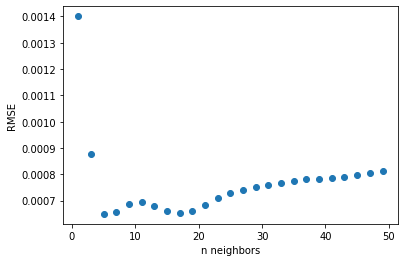

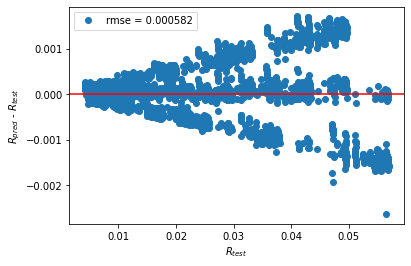

Fitting 3 folds for each of 25 candidates, totalling 75 fits
0.0075 {'n_neighbors': 5, 'weights': 'distance'}


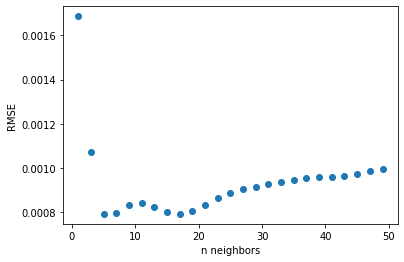

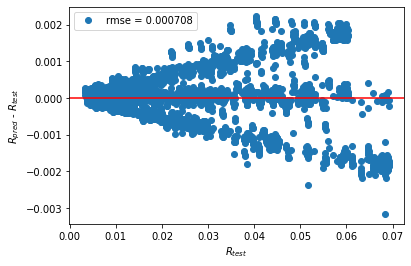

Fitting 3 folds for each of 25 candidates, totalling 75 fits


In [ ]:
for d1 in [0.075, 0.1, 0.125, 0.15, 0.175, 0.2, 0.225, 0.25, 0.275]:
    mask = data['d1'] == d1
    optical_prop = data[mask][log_optical]
    data_R = data[mask][Rs]
    X_train, X_test, ys_train, ys_test = train_test_split(optical_prop, data_R, test_size=0.05, random_state=42)
    best_params = {}
    best_estimators = {}
    for col in data_R.columns[data_R.columns<'0.9975']:
        y_train = ys_train[col]
        y_test = ys_test[col]
        parameters = {'weights':['distance'] ,
                      'n_neighbors':np.arange(1,50,2)}
        neigh = KNeighborsRegressor()
        clf = GridSearchCV(neigh, parameters,scoring='neg_root_mean_squared_error',n_jobs=-1,verbose=2,cv=3)
        clf.fit(X_train, y_train)

        best_params[col]=(clf.best_params_)
        print(col,clf.best_params_)

        plt.figure()
        plt.plot(np.arange(1,50,2),-clf.cv_results_['mean_test_score'],'o')
        plt.xlabel('n neighbors')
        plt.ylabel('RMSE')
        plt.show()

        best_estimators[col]=clf.best_estimator_
        y_pred = clf.best_estimator_.predict(X_test)
        dump(clf.best_estimator_, f'knn_reg_d_{col}_d1_{d1}.joblib')

        res = stats.linregress(y_test, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))

        plt.figure()
        plt.plot(y_test,y_pred-y_test,'o',label=f"rmse = {rmse:.6f}")
        plt.axhline(0,color='red')
        plt.xlabel('$R_{test}$')
        plt.ylabel('$R_{pred}$ - $R_{test}$')
        plt.legend()
        plt.show()